# An oversimplified energy system model

In [1]:
import pyomo.environ as pyo
import pandas as pd
import plotly.express as px

## Function definitions

In [2]:
def model_vars_as_dfs(model, debug=False) -> dict[str, pd.DataFrame]:
    df_dict = {}
    # loop over all variables
    for m_var in model.component_objects(pyo.Var, active=True):
        # store values in a series
        var_values = pd.Series(m_var.get_values())

        # get names of indices
        subsets = list(m_var.index_set().subsets())
        subset_names = [x.name for x in subsets]

        # print information if desired
        if debug:
            print(f"{m_var} is indexed in {subset_names}")

        # transform to dataframe and store in dictionary
        df = var_values.to_frame().reset_index()
        df.columns = subset_names + ["value"]
        df_dict[f"{m_var}"] = df.copy()

    return df_dict

## gather time series

In [3]:
# Toronto:
lat, lon =43.712148, -79.304524
pv_peak_power = 1
url = f"https://re.jrc.ec.europa.eu/api/v5_2/seriescalc?lat={lat}&lon={lon}&raddatabase=PVGIS-NSRDB&browser=1&outputformat=csv&userhorizon=&usehorizon=1&angle=&aspect=&startyear=2014&endyear=2014&mountingplace=free&optimalinclination=0&optimalangles=1&js=1&select_database_hourly=PVGIS-NSRDB&hstartyear=2014&hendyear=2014&trackingtype=0&hourlyoptimalangles=1&pvcalculation=1&pvtechchoice=crystSi&peakpower={pv_peak_power}&loss=0&components=1"
solar_data = pd.read_csv(url, header=8)

# clear values that are not available
na = solar_data["T2m"].isna()
solar_data = solar_data.loc[~na,:]
solar_data.loc[:,"P":] = solar_data.loc[:,"P":].astype(float)
solar_data["cf"] = solar_data["P"] / (pv_peak_power*1000)
solar_data.head()


,time,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int,cf
0,20140101:0000,0.0,0.0,0.0,0.0,0.0,-9.60,7.52,0.0,0.0
1,20140101:0100,0.0,0.0,0.0,0.0,0.0,-9.73,6.90,0.0,0.0
2,20140101:0200,0.0,0.0,0.0,0.0,0.0,-9.70,6.41,0.0,0.0
3,20140101:0300,0.0,0.0,0.0,0.0,0.0,-9.61,6.62,0.0,0.0
4,20140101:0400,0.0,0.0,0.0,0.0,0.0,-9.53,6.62,0.0,0.0


In [4]:
eff_df = solar_data["cf"].to_frame()
eff_df.loc[:,"coal"] = 0.38
eff_df.loc[:,"gas"] = 0.5
eff_df.rename({"cf":"pv"}, axis=1, inplace=True)


In [5]:
eff_df_long = eff_df.melt(ignore_index=False).reset_index().set_index(["variable","index"])
eff_df_long = eff_df_long.sort_index()

In [6]:

ontario_demand = pd.read_csv("http://reports.ieso.ca/public/Demand/PUB_Demand_2014.csv", header=3)


# ontario_demand["Ontario Demand"] *= 1/ontario_demand["Ontario Demand"].sum()
ontario_demand.tail()


,Date,Hour,Market Demand,Ontario Demand
8755,2014-12-31,20,21226,18010
8756,2014-12-31,21,20404,17294
8757,2014-12-31,22,19710,16759
8758,2014-12-31,23,19167,16123
8759,2014-12-31,24,18614,15469


In [7]:
import numpy as np
random_demand = np.random.random(len(ontario_demand["Ontario Demand"])) * max(ontario_demand["Ontario Demand"])
# ontario_demand["Ontario Demand"] += random_demand

# Model definition

In [8]:
esm = pyo.ConcreteModel("Oversimplified ontario electricity model")

t_start = 3000
t_end = t_start + 12*24

esm.hour = pyo.RangeSet(t_start, t_end)
esm.gen_types = pyo.Set(initialize=["pv", "coal", "gas"])

esm.demand = pyo.Param(esm.hour, initialize=ontario_demand.loc[t_start:t_end,"Ontario Demand"].to_dict(), within=pyo.NonNegativeReals)
esm.cf = pyo.Param(esm.hour, initialize=solar_data.loc[t_start:t_end,"cf"].to_dict(), within=pyo.NonNegativeReals)
esm.fuel_cost = pyo.Param(esm.gen_types, initialize={"pv":0, "coal":207, "gas":309})
esm.inv_cost = pyo.Param(esm.gen_types, initialize={"pv":1201, "coal":502, "gas":203})
esm.efficiency = pyo.Param(esm.gen_types, esm.hour, initialize=eff_df_long.loc[:,t_start:t_end,:].to_dict()["value"])


esm.generation = pyo.Var(esm.gen_types, esm.hour, within=pyo.NonNegativeReals)
# if invest:
esm.capacity = pyo.Var(esm.gen_types, within=pyo.NonNegativeReals)
# else:
# esm.capacity = pyo.Param(esm.gen_types, initialize={'pv': 584261.407579273, 'coal': 54650.0, 'gas': 1018.0})

demand_response=False

if demand_response:
    esm.demand_shift_up = pyo.Var(esm.hour, within=pyo.NonNegativeReals, bounds=(0,3000))
    esm.demand_shift_down = pyo.Var(esm.hour, within=pyo.NonNegativeReals, bounds=(0,3000))


## constraints

In [9]:

# energy balance
def balance(m, h):
  if demand_response:
    return  m.demand[h] <= sum(m.generation[gt, h] for gt in m.gen_types) - m.demand_shift_up[h] + m.demand_shift_down[h]
  else:
    return  m.demand[h] <= sum(m.generation[gt, h] for gt in m.gen_types)

if hasattr(esm,"balance_constraint"):
  esm.del_component("balance_constraint")
esm.balance_constraint = pyo.Constraint(esm.hour, rule=balance)


if demand_response:
  def demand_response_constraint(m,h):
    # print(h,h+1 in m.hour)
    return sum(m.demand_shift_up[h-i] for i in range(4) if h-i in m.hour) == sum(m.demand_shift_down[h+i] for i in range(4) if h+i in m.hour)
  esm.dr_constraint = pyo.Constraint(esm.hour, rule=demand_response_constraint)



# capacity constraint
def cap_const(m, h, gt):
  return m.generation[gt, h] <= m.capacity[gt] * m.efficiency[gt, h]
esm.capacity_constraint = pyo.Constraint(esm.hour, esm.gen_types, rule=cap_const)

# pv limit
def pv_cap_constr(m,):
  return m.capacity["pv"] <= 30000
esm.pv_limit = pyo.Constraint(rule=pv_cap_constr)

def gen_share_limit(m, gt, limit):
  return sum(m.generation[gt, h] for h in m.hour)/ sum(m.demand[h] for h in m.hour) <= limit

coal_limit = False
if coal_limit:
  esm.coal_limit = pyo.Constraint(["coal"], [0.5], rule=gen_share_limit)


def cost(m,):
  return sum(m.generation[gt,h]*m.fuel_cost[gt] for gt in m.gen_types for h in m.hour) + \
    sum(m.capacity[gt] * m.inv_cost[gt] for gt in m.gen_types)

if hasattr(esm,"objective"):
  esm.del_component("objective")
esm.objective = pyo.Objective(rule=cost)


In [10]:
esm.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
opt = pyo.SolverFactory("gurobi")
result = opt.solve(esm)
opt_vars = model_vars_as_dfs(esm)

dual_dfs = {}

# f.write("eq,year,hour,node,dual_price\n")
duals_of_interest = ["balance_constraint"]
for c in esm.component_objects(pyo.Constraint, active=True):
    # export only the marginals of constraints in that list
    print(c)
    vals = {}
    if str(c) in duals_of_interest:
        for index in c:
            vals[index] = esm.dual[c[index]]
    dual_df = pd.DataFrame(vals.values(), index=vals.keys(), columns=["dual"])
    dual_dfs[f"{c}"] = dual_df


In [12]:
pyo.value(esm.objective)
# 15514472240.481754
#     1015756.107998 (sum of marginals)
# so with all demand + 1 should be:
# ontario_demand["Ontario Demand"] += 1
# 15515487996... 
# and it is!! (for coal_limit=False )
# 15515487996.589754

600721720.5105265

In [14]:
dual_df = dual_dfs["balance_constraint"]
price_duration = dual_df.sort_values(by="dual", ascending=False).reset_index(names=["old_idx"])
fig = px.line(price_duration.reset_index(), x="index", y="dual", hover_data=["old_idx"])
fig.update_layout(width=600, height=400, title="load duration curve")

In [15]:
if demand_response:
    dr_df = opt_vars["demand_shift_down"].rename({"value":"down"}, axis=1)
    dr_df["up"] = opt_vars["demand_shift_up"]["value"]
    # dr_df.set_index("hour").plot()

In [16]:


dual_df["old_demand"] = ontario_demand.loc[t_start:t_end,"Ontario Demand"]
dual_df["post_dr_demand"] = ontario_demand.loc[t_start:t_end,"Ontario Demand"]

if demand_response:
    dual_df["post_dr_demand"] = dual_df["old_demand"] + dr_df["up"].values - dr_df["down"].values
    dual_df["dr_shift"] = dr_df["up"].values - dr_df["down"].values

# dual_df.melt(ignore_index=False)
fig = px.line(dual_df.melt(ignore_index=False).reset_index(),x="index",y="value", facet_row="variable" )
fig.update_yaxes(matches=None)
# ontario_demand.loc[t_start:t_end,"Ontario Demand"].plot()

In [17]:
price_duration["dual"].sum()
# 1015756.1079984119
# however, the marginals don't change for
# ontario_demand["Ontario Demand"] += 1
# 1015756.1079984119

# nor do they change for 
# ontario_demand["Ontario Demand"] *= 2
# 1015756.1079984119

# but it does change for random demand additions:
# 1014357.3627871022 # ... but decreases?
# so shape shifting, is the only way to change marginals

# for demand.sum = 1
# 1049787.9184475108

49552.05263157895

In [18]:
price_duration["dual"].mean()

# 119.83880347574325 # <- with invest
# 119.80342465753425 # <- without invest


171.46038972864687

In [19]:
(dual_dfs["balance_constraint"]["dual"] * dual_df["post_dr_demand"]).sum() / dual_df["post_dr_demand"].sum()
# 114.62626668476345 <- without invest
# 114.68167861367824 <- with invest

# 166.302 with dr=3000, and 4 hours each direction and pv_cap=30k
# 130.542 with dr=3000, and 4 hours each direction and no pv_cap!
# 136.342 with no dr and no pv_cap
# 169.195 with no dr and pv_cap=30k

169.19526930982582

In [20]:
pyo.value(esm.objective) / dual_df["post_dr_demand"].sum()

# note that the introduction of a pv capacity limit alters sth, such that S_c/sum(D) != weighted marginal
# 141.049 with dr=3000, and 4 hours each direction and pv_cap=30k
# 130.542 with dr=3000, and 4 hours each direction and no pv_cap!
# 136.342 with no dr and no pv_cap
# 145.631 with no dr and pv_cap=30k

145.63180280671733

In [21]:

fig = px.area(opt_vars["generation"], x="hour", y="value", color="gen_types")
fig.update_traces(line=dict(width=0))

fig.update_layout(width=600, height=400)

In [22]:
fig = px.area(dual_dfs["balance_constraint"]["dual"] ,)#color="gen_types")
fig.update_traces(line=dict(width=0))

fig.update_layout(width=600, height=400)

In [23]:
# optimal_capacities = opt_vars["capacity"].set_index("gen_types").to_dict()["value"]
# optimal_capacities = {'pv': 584261.407579273, 'coal': 54650.0, 'gas': 1018.0}

## simple demand shift implementation

1) capture timesteps with lowest price, and (iteratively) add demand to these timesteps
2) added demand needs to be subtracted from adjacent timesteps
3) this sounds like performing a moving average

<Axes: xlabel='t'>

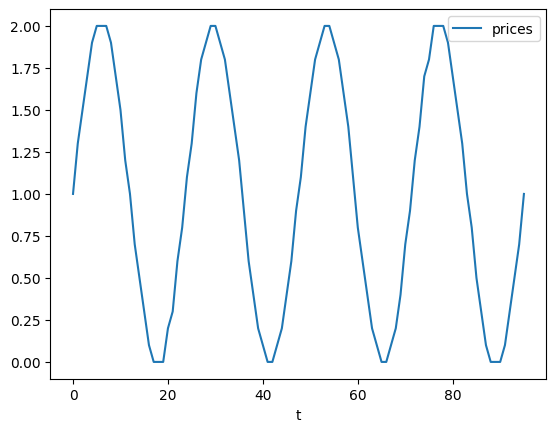

In [24]:
import numpy as np
import pandas as pd

t = np.linspace(0,8*np.pi,96)
dummy_prices = np.round(np.sin(t) + 1 ,1)
dummy_demand = np.round(np.sin(t) + 1 ,1)

df = pd.DataFrame({"t":range(len(t)), "prices":dummy_prices}).set_index("t")
df.plot()

In [25]:
# 10 hour lookahead

max_lookahead = 10

for i,price in enumerate(dummy_prices):
    for j in range(1, max_lookahead+1):
        pass

## household demand shift esm
